In [1]:
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


from farich_functions import *

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
datadir = 'data'

In [4]:
filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_no.root')
filepath_low_energies = os.path.join(datadir, 'fullsim_optical_10000_pi_500_800_no.root')
filepath_monodir = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_monodir_no.root')
filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [5]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
file_low= uproot.open(filepath_low_energies)
# file = uproot.open(filepath_monodir)
# file_2pi = uproot.open(filepath_2pi)
# file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [6]:
plt.style.use('default')

In [7]:
# plot_cyl(file, transposed=True)

In [8]:
# np.concatenate(np.array(file['events;1']['FarichBarrelG4Hits.postStepPosition.x'].array())).shape

# Main (tmp obv)

In [9]:
def init_sipm_eff():
    pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
    t1 = []
    t2 = []
    for inedx, row in pdes_tmp.iterrows():
        t1.append(float(row['A'].split(';')[0].replace(',', '.')))
        t2.append(float(row['A'].split(';')[1].replace(',', '.')))
    PDE_wvs = np.linspace(200, 900, 128)
    PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
    sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)
    return sipm_eff, PDE_wvs

In [10]:
sipm_eff, PDE_wvs = init_sipm_eff()

In [11]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [12]:
MAXIMUM_EVENT_GROUP_NUMBER = 13
MAXIMUM_EVENT_GROUP_NUMBER_LOW = 10 

In [13]:
def init_coords(file, MAXIMUM_EVENT_GROUP_NUMBER):
    x = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.x'].array())
    y = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.y'].array())
    z = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.z'].array())
    wvs = 1239.841 / np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.energy'].array()) * 1e-9
    x3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.px'].array())
    y3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.py'].array())
    z3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.pz'].array())
    true_direction_coordinates = np.column_stack((x3, y3, z3))
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs))
    return coordinates, true_direction_coordinates

In [14]:
coordinates, true_direction_coordinates = init_coords(file, MAXIMUM_EVENT_GROUP_NUMBER)
coordinates_low, true_direction_coordinates_low = init_coords(file_low, MAXIMUM_EVENT_GROUP_NUMBER_LOW)

In [15]:
# x = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.x'].array())
# y = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.y'].array())
# z = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.z'].array())
# wvs = 1239.841 / np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [16]:
# x1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.x'].array())
# y1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.y'].array())
# z1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.z'].array())
# drift_chamber_coordinates = np.column_stack((x1, y1, z1))

In [17]:
# x2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.x'].array())
# y2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.y'].array())
# z2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.z'].array())
# tpc_coordinates = np.column_stack((x2, y2, z2))

In [18]:
# x3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.px'].array())
# y3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.py'].array())
# z3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.pz'].array())
# true_direction_coordinates = np.column_stack((x3, y3, z3))

In [19]:
# for i in range(len(wvs)):
#     wvs[i] = lin_move_to_grid(wvs[i], grid[2])

In [20]:
coordinates = np.concatenate((coordinates, coordinates_low), axis=0)
true_direction_coordinates = np.concatenate((true_direction_coordinates, true_direction_coordinates_low), axis=0)

In [21]:
# coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(20000, 4)

In [22]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [23]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)
print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19938, 4)
(19938, 3)


In [24]:
# ev = 123
# plot_event(coordinates[ev], None, None, np.stack([np.concatenate(true_direction_coordinates[ev]), np.concatenate(true_direction_coordinates[ev] * 3000)], axis=1))
# То есть есть события, когда направление первичной частицы не попадает в кольцо. Почему?


In [25]:
sipm_sim(coordinates, sipm_eff)

In [26]:
# plot_cyl(file, coordinates, True)

In [27]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)

print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19599, 4)
(19599, 3)


In [28]:
main_angles = rotate_lines(true_direction_coordinates)

In [29]:
intersections = find_intersections(true_direction_coordinates)

[array([0.00329075]) array([1.06504879]) array([0.96075904])]


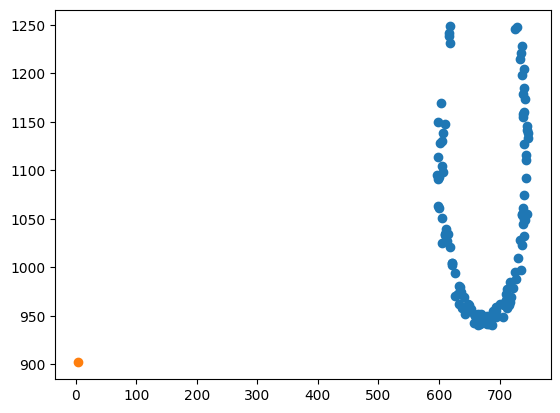

In [30]:

num = 30 # unturned events
# plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
plt.scatter(coordinates[num][0], coordinates[num][2])
plt.scatter(intersections[num][0], intersections[num][2])
print(true_direction_coordinates[num])
plt.show()

In [31]:
# plot_event(coordinates[num], drift_chamber_coordinates[num],tpc_coordinates[num] , transposed=True)

In [32]:
rotate_events(coordinates, main_angles)

In [33]:
# plot_cyl(file, coordinates)

In [34]:
move_events_to_grid(coordinates, grid)

In [35]:
# plot_cyl(file, coordinates, True)

In [36]:
# num = 2
# # plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
# plt.scatter(coordinates[num][0], coordinates[num][2])
# plt.scatter(intersections[num][0], intersections[num][2])
# plt.show()

In [37]:
r_c = (coordinates[:,0] - intersections[:,0]) ** 2 + (coordinates[:,1] - intersections[:,1]) ** 2

In [38]:
repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])

In [39]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
edf['r_c'] = r_c

In [40]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [41]:
unraveled_df['r_c'] = np.sqrt(unraveled_df.r_c)

In [42]:
edf = unraveled_df

In [43]:
edf['x_i'] = np.repeat(intersections[:,0], repeat_nums, axis=0)
edf['z_i'] = np.repeat(intersections[:,2], repeat_nums, axis=0)

In [44]:
x = y = z = x3 = y3 = z3 = unraveled_data = row_indices = main_angles = intersections = wvs = coordinates = file = coordinates_low = file_low = 0

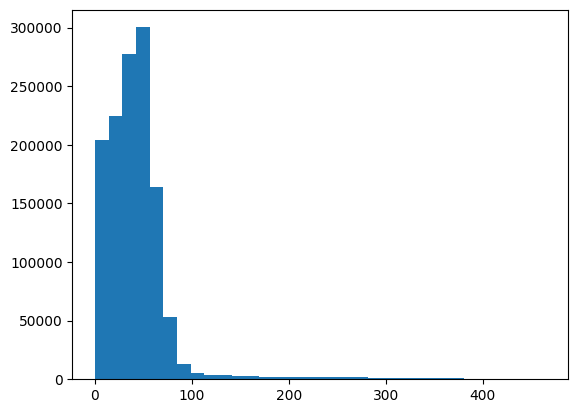

In [45]:
plt.hist(edf[edf.r_c<1000].r_c, bins='doane')
plt.show()

In [46]:
bdf = pd.DataFrame()
edf['t_c'] = np.zeros(edf.shape[0])
edf.drop('y_c', axis=1, inplace=True)
edf.rename(columns={'z_c': 'y_c', 'z_i': 'y_i'}, inplace=True)
edf['z_c'] = np.zeros(edf.shape[0]) + 2000
edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
edf['beta'] = edf.true_p / np.sqrt(139.57 ** 2 + edf.true_p ** 2)
edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,0], repeat_nums, axis=0)
edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,2], repeat_nums, axis=0)
edf['nz_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,1], repeat_nums, axis=0)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\1986587013.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\1986587013.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\1986587013.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a sca

In [47]:
true_direction_coordinates = repeat_nums = true_direction_coordinates_low = 0

In [48]:
edf.shape[0]

1279810

In [49]:
idf = pd.DataFrame()
# idf['W'] = [35.]
idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [200.]
# idf['n_mean'] = [1.0454]

idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]

In [50]:
idf

,W,zdis,distance,n_mean,pixel_size
0,40.0,800.0,200.0,1.0502,3.16


In [51]:
edf = applySpaceCut(edf)

In [52]:
planeRecalculation(edf, idf)

Z:\Prog\FARICH\farich_functions.py:377: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha = (float(dist)) / N[:, 2]
Z:\Prog\FARICH\farich_functions.py:390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['t_c'] = edf['t_c'] + np.sign(R_new[:, 2] - R[:, 2]) * t_dif
Z:\Prog\FARICH\farich_functions.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['recalculated_x'] = R_new[:, 0]
Z:\Prog\FARICH\farich_

In [53]:
edf['x_p'] = np.zeros(edf.shape[0])
edf['y_p'] = np.zeros(edf.shape[0])
edf['z_p'] = np.zeros(edf.shape[0])


C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\210028248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['x_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\210028248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['y_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\210028248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [54]:
planeRotation(edf)

Z:\Prog\FARICH\farich_functions.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_x'] = rotated_R[:,0]
Z:\Prog\FARICH\farich_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_y'] = rotated_R[:,1]
Z:\Prog\FARICH\farich_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [55]:
edf = applySecondSpaceCut(edf)

In [56]:
bdf = pd.DataFrame()
edf_to_bdf(edf.r_c.groupby(level=0).transform('mean'), bdf)
bdf.rename(columns={'r_c': 'r_c_mean'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform('std'), bdf)
bdf.rename(columns={'r_c': 'r_c_std'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform(lambda x: x.max() - x.min()), bdf)
bdf.rename(columns={'r_c': 'r_c_width'}, inplace=True)
edf_to_bdf(edf.true_p, bdf)
bdf.rename(columns={'true_p': 'momentum'}, inplace=True)

In [57]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0         123.040131  135.52  530.708661  51.800917  71.239214   
      1          32.320131  155.68  414.960630  38.919083  71.239214   
      2         126.400131   85.12  470.078740  55.160917  71.239214   
      3          65.920131  169.12  365.354331   5.319083  71.239214   
      4         126.400131  118.72  481.102362  55.160917  71.239214   
...                    ...     ...         ...        ...        ...   
19598 56       -128.959869 -257.60  481.102362  51.432542 -77.527328   
      57       -128.959869 -267.68  492.125984  51.432542 -77.527328   
      58        -71.839869 -220.64  387.401575   5.687458 -77.527328   
      59        -95.359869 -321.44  481.102362  17.832542 -77.527328   
      60        -71.839869 -224.00  448.031496   5.687458 -77.527328   

                       y_i       t_c     z_c       true_p      beta  ...  z_p  \
entry subentry                                                       ...        
0     0         102.379707 -0.023488  2000.0  1408.464406  0.995126  ...  0.0   
      1         102.379707 -0.008931  2000.0  1408.464406  0.995126  ...  0.0   
      2         102.379707 -0.007195  2000.0  1408.464406  0.995126  ...  0.0   
      3         102.379707 -0.021416  2000.0  1408.464406  0.995126  ...  0.0   
      4         102.379707 -0.018595  2000.0  1408.464406  0.995126  ...  0.0   
...                    ...       ...     ...          ...       ...  ...  ...   
19598 56       -264.051164 -0.007533  2000.0   768.426547  0.983902  ...  0.0   
      57       -264.051164 -0.016281  2000.0   768.426547  0.983902  ...  0.0   
      58       -264.051164  0.039650  2000.0   768.426547  0.983902  ...  0.0   
      59       -264.051164 -0.054015  2000.0   768.426547  0.983902  ...  0.0   
      60       -264.051164  0.036667  2000.0   768.426547  0.983902  ...  0.0   

                 rotated_x   rotated_y    rotated_z  rotated_x_i  rotated_y_i  \
entry subentry                                                                  
0     0         -19.026015  -68.401037  2000.059575   -70.691475  -101.592538   
      1        -109.456665  -48.318415  2000.059575   -70.691475  -101.592538   
      2         -15.578219 -118.744564  2000.059575   -70.691475  -101.592538   
      3         -75.824064  -34.987904  2000.059575   -70.691475  -101.592538   
      4         -15.653674  -85.132490  2000.059575   -70.691475  -101.592538   
...                    ...         ...          ...          ...          ...   
19598 56         23.355071  260.824230  2001.332499    74.748497   254.586716   
      57         23.400465  250.537873  2001.332499    74.748497   254.586716   
      58         80.805024  299.497056  2001.332499    74.748497   254.586716   
      59         56.736694  196.541595  2001.332499    74.748497   254.586716   
      60         80.777261  295.992978  2001.332499    74.748497   254.586716   

                rotated_z_i  rotated_nx_p  rotated_ny_p  rotated_nz_p  
entry subentry                                                         
0     0         2000.059575     -0.035277     -0.050698      0.998091  
      1         2000.059575     -0.035277     -0.050698      0.998091  
      2         2000.059575     -0.035277     -0.050698      0.998091  
      3         2000.059575     -0.035277     -0.050698      0.998091  
      4         2000.059575     -0.035277     -0.050698      0.998091  
...                     ...           ...           ...           ...  
19598 56        2001.332499      0.037025      0.126105      0.991326  
      57        2001.332499      0.037025      0.126105      0.991326  
      58        2001.332499      0.037025      0.126105      0.991326  
      59        2001.332499      0.037025      0.126105      0.991326  
      60        2001.332499      0.037025      0.126105      0.991326  

[1247273 rows x 28 columns]

In [58]:
bdf.isna().sum()

r_c_mean     0
r_c_std      2
r_c_width    0
momentum     0
dtype: int64

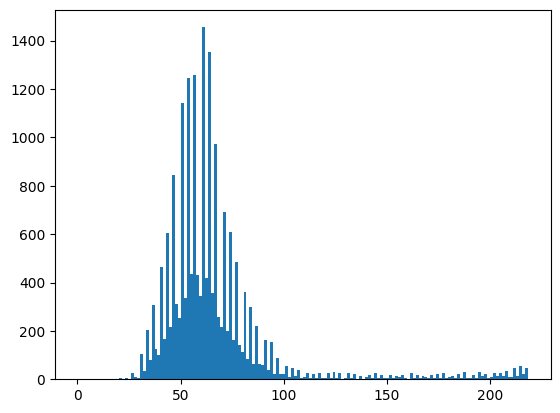

In [59]:
plt.hist(bdf[bdf.r_c_width < 1000].r_c_width, bins='auto')
plt.show()

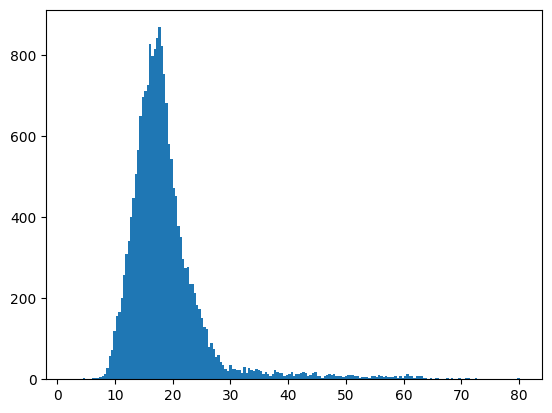

In [60]:
plt.hist(bdf[bdf.r_c_std < 1000].r_c_std, bins='auto')
plt.show()

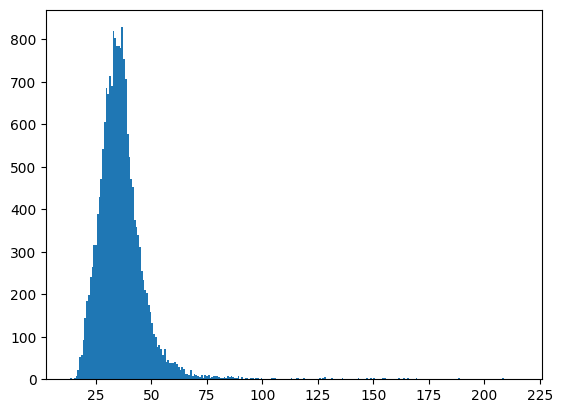

In [61]:
plt.hist(bdf[bdf.r_c_mean < 1000].r_c_mean, bins='auto')
plt.show()

In [62]:
# np.tan(1 / (edf.beta.iloc[0] * idf.n_mean)) 

In [63]:
# idf.W * np.tan(1/(idf.n_mean * edf.beta.iloc[0]))

In [64]:
# num = 7
# event = edf.loc[num]
# plt.scatter(event.rotated_x, event.rotated_y)
# plt.scatter(event.rotated_x_i, event.rotated_y_i)
# plt.show()

In [65]:
primaryDirectionRecalculation(edf)

In [66]:
edf['rotated_r_c'] = np.sqrt((edf['rotated_x_i'] - edf['rotated_x']) ** 2 + (edf['rotated_y_i'] - edf['rotated_y']) ** 2)
edf['signal'] = np.ones(edf.shape[0])

In [67]:
recoAngles(edf, idf)

Z:\Prog\FARICH\farich_functions.py:496: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf['distance'])
Z:\Prog\FARICH\farich_functions.py:499: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf['W'])
Z:\Prog\FARICH\farich_functions.py:502: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf['zdis'])


In [68]:
recoAngles(edf, idf, rotation_mode=True)

Z:\Prog\FARICH\farich_functions.py:496: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf['distance'])
Z:\Prog\FARICH\farich_functions.py:499: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf['W'])
Z:\Prog\FARICH\farich_functions.py:502: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf['zdis'])
Z:\Prog\FARICH\farich_functions.py:517: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  n_mean = float(idf['n_mean'])


In [69]:
def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = False, weighed=True, deg_lim=False, param_fit=False, calibration_func=pol, param_calibration_func=d3pol2, 
                num_of_calibration_params=3, num_of_param_fit_params=3, target_variable = 'momentum', target_angle = 'theta_p', num_of_theta_intervals=11, p0=(100, 1, 100)):  
  to_return_unbinned = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, num_of_calibration_params), 0.)

  errs_tmp = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, num_of_calibration_params), 0.)
  fit_params = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_calibration_params, num_of_param_fit_params), 0.)
  
  
  dir_to_save = f"{'weighed' if weighed else 'unweighed'}_rw={step}_tw={t_window_width}_rs={r_width_factor}_ts={t_width_factor}"
  if not os.path.exists(os.path.join('calibrations_barrel', dir_to_save)):
    os.mkdir(os.path.join('calibrations_barrel', dir_to_save))
      
      
  for r_sigms in range(*avg_sigmas):
    fig, axs = plt.subplots(num_of_theta_intervals - 1, np.ptp(avg_t_sigmas), figsize=(16 * np.ptp(avg_t_sigmas), 9 * (num_of_theta_intervals - 1)))
    for t_sigms in range(*avg_t_sigmas):
      chosen_column = f'unfixed_calculated_r_2d_{r_sigms}_rsigms_{t_sigms}_tsigms'

      calibration_loop(bdf, chosen_column, r_sigms, t_sigms, num_of_theta_intervals, to_return_unbinned, errs_tmp, fig, axs, avg_sigmas, avg_t_sigmas, target_variable, target_angle, calibration_func, p0)
      if param_fit:
        param_fit_calibration(bdf, chosen_column, r_sigms, t_sigms, avg_sigmas, avg_t_sigmas, fit_params, target_variable, target_angle, param_calibration_func)   
    save_calibration_plot(fig, dir_to_save, deg_lim, r_sigms, avg_t_sigmas)        



  if param_fit:
    return fit_params
  return to_return_unbinned
# cal_arr = np.array(calibration(edf, bdf, avg_sigmas=(1, 5), avg_t_sigmas=(1, 5))) # add r and t calibr - done

C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\3263025033.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,


In [70]:
def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = True, num_of_groups=5, weighed=True, deg_lim=False, param_fit=False, 
                   calibration_func=pol, param_calibration_func=d3pol2, num_of_calibration_params=3, num_of_param_fit_params=3, target_variable='beta', target_angle='cos_theta_p', num_of_theta_intervals=11, p0=(100, 1, 100)):
  rSlidingWindowIntro(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, num_of_groups=num_of_groups)
  calculateSignalCounts(edf, bdf)
  rSlidingWindowLoop1(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, full_width_t_hist=full_width_t_hist, weighed=weighed)
  bdf.dropna(subset=['unfixed_calculated_r_2d_4_rsigms_4_tsigms'], inplace=True)
  edf.dropna(subset=['unfixed_calculated_r_2d_4_rsigms_4_tsigms'], inplace=True)
  if cal_arr is False:
    cal_arr = np.array(calibration(edf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, step=step, t_window_width=t_window_width,
                                   r_width_factor=r_width_factor, t_width_factor=t_width_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params, target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0)) 
  rSlidingWindowLoop2(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, param_fit=param_fit, calibration_func=calibration_func, param_calibration_func=param_calibration_func, target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals)
  return cal_arr

C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\579870497.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,


In [71]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
r_width = float(idf.pixel_size) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False # WORKS
# sample_size = 12
cal_arr = False
beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []

C:\Users\BRINE\AppData\Local\Temp\ipykernel_9264\1724634637.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r_width = float(idf.pixel_size) * 2


In [72]:
def exp_like(X, a, b):
    return a * np.exp(b * X)

In [73]:
def pol2_exp_like(X, a0, a1, a2, b0, b1, b2):
    r, theta = X
    return exp_like(r, a0 + a1 * theta + a2 * theta ** 2, b0 + b0 * theta + b1 * theta ** 2)

In [74]:
def pol3(X, p0, p1, p2, p3):
    return p0 + p1 * X + p2 * X ** 2 + p3 * X ** 3

In [75]:
cal_arr = rSlidingWindow(edf, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, num_of_groups=num_of_groups,
                               step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, 
                         calibration_func=pol, param_calibration_func=pol2_exp_like, num_of_calibration_params=3, num_of_param_fit_params=3, target_variable='beta', target_angle='theta_p', num_of_theta_intervals=6, p0=(100, 1, 100))

Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeWarning: invalid value encountered in scalar divide
  return weighted_sum / weighted_den
Z:\Prog\FARICH\farich_functions.py:592: RuntimeW

0


In [76]:
cal_arr

array([[[[  0.95966118,  -2.11822158, 309.53502807],
         [  0.95240301, -21.74738937, 382.16452133],
         [  0.96546373,  10.62963458, 289.09150877],
         [  0.96774607,  19.09434377, 287.49654439],
         [  0.97001277,  34.34108017, 245.80522117]]]])

In [77]:
bdf

,r_c_mean,r_c_std,r_c_width,momentum,beta_group,theta_p,cos_theta_p,beta,signal_counts,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
0,41.021615,16.978743,63.840000,1408.464406,10.0,0.124085,0.992311,0.995126,85.0,54.608282,0.992439,-0.002687,-0.269996
1,37.382643,19.878506,67.200000,932.768102,8.0,0.454187,0.898618,0.988990,74.0,61.750764,0.996131,0.007141,0.722044
2,49.438648,22.314954,84.000000,770.366650,7.0,0.761376,0.723888,0.983981,77.0,64.671822,0.984895,0.000914,0.092863
3,31.746091,14.510550,53.760000,868.738138,8.0,0.117904,0.993057,0.987339,56.0,48.601920,0.985777,-0.001562,-0.158212
4,36.915370,19.813850,65.593319,891.133356,8.0,0.307330,0.953145,0.987956,72.0,52.580609,0.989120,0.001164,0.117791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19429,19.009534,10.226519,33.286052,511.674644,1.0,0.348391,0.939923,0.964753,22.0,29.765228,NaN,NaN,NaN
19430,19.033102,10.043555,35.688238,516.389412,1.0,0.118930,0.992936,0.965361,22.0,28.199274,NaN,NaN,NaN
19431,21.374370,10.251920,33.600000,506.448844,1.0,0.282434,0.960380,0.964061,27.0,28.284867,NaN,NaN,NaN
19432,32.515954,15.790180,53.760000,594.951706,4.0,0.582811,0.834919,0.973570,46.0,37.049929,NaN,NaN,NaN


In [78]:
momentum_from_beta(0.985, 139.57)

796.7139544777222

In [79]:
# edf.loc[30]

In [80]:
min(bdf.cos_theta_p)

0.7033225901526667

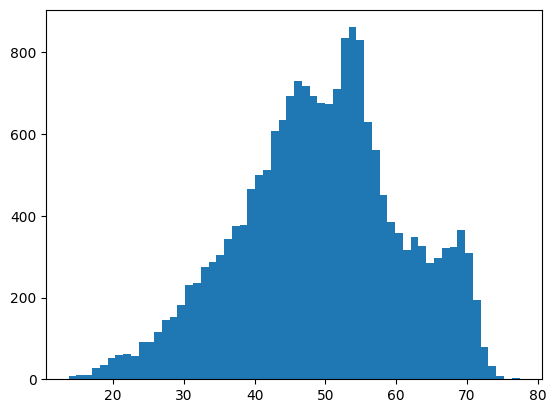

In [81]:
plt.hist(bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins='auto')
plt.show()

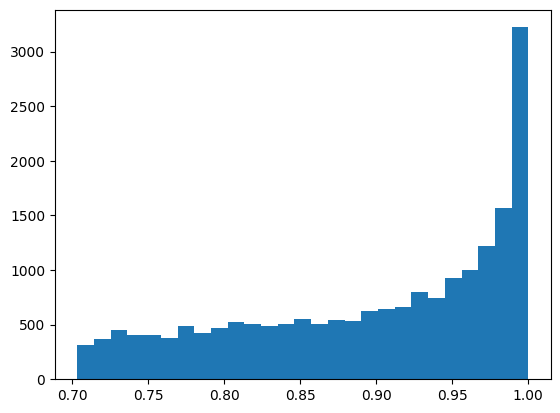

In [82]:
plt.hist(bdf.cos_theta_p, bins='auto')
plt.show()

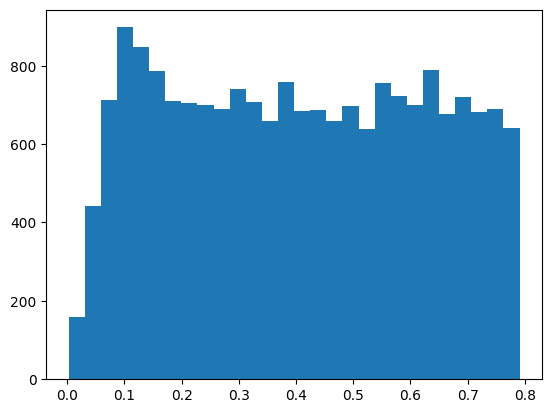

In [83]:
plt.hist(bdf.theta_p, bins='auto')
plt.show()

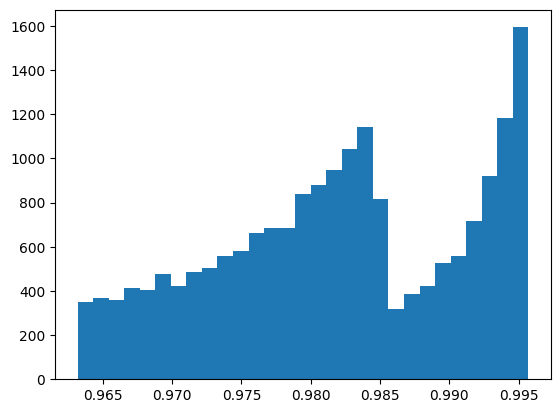

In [84]:
plt.hist(bdf.beta, bins='auto')
plt.show()

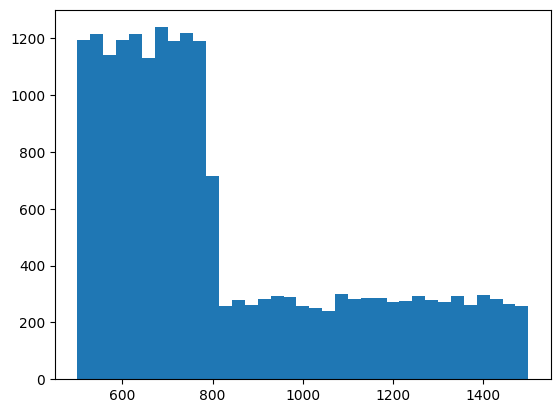

In [85]:
plt.hist(bdf.momentum, bins='auto')
plt.show()

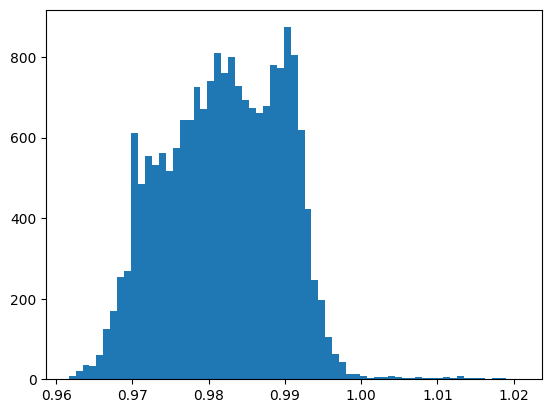

In [86]:
plt.hist(bdf.beta_from_calc_r_4_rsigms_4_tsigms, bins='auto')
plt.show()

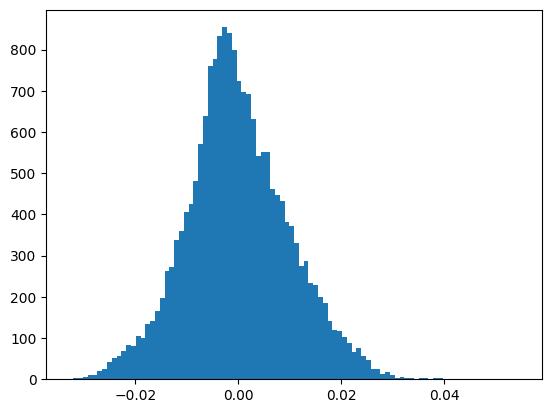

In [87]:
plt.hist(bdf.beta_from_calc_r_4_rsigms_4_tsigms - bdf.beta, bins='auto')
plt.show()

In [88]:
ф

NameError: name 'ф' is not defined

In [ ]:
bdf[bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms.isna()] # All rings with intersections outside the ring itself

In [ ]:
bdf.isna().sum()

In [ ]:
bdf.dropna().isna().sum()

In [ ]:
event = edf.loc[30]
plt.subplot()
plt.scatter(event.phi_c, event.theta_c)
plt.show()
plt.subplot()
plt.gca().invert_yaxis()
plt.scatter(event.rotated_x, event.rotated_y)
plt.scatter(event.rotated_x_i, event.rotated_y_i)
plt.show()

In [ ]:
event

In [ ]:
plt.hist(bdf.beta - bdf.beta_from_calc_r_4_rsigms_4_tsigms, bins='auto')
plt.show()

In [ ]:
def rms90(arr):
    # Calculate the mean and standard deviation of the array
    arr = arr.dropna()
    # arr_mean = np.mean(arr)
    # arr_std = np.std(arr)

    # Define the upper and lower limits for the 90% range
    lower_limit = np.percentile(arr, 5)
    upper_limit = np.percentile(arr, 95)
    # print(lower_limit, upper_limit)
    # print(arr)
    # Select the values within the 90% range
    arr_filtered = arr[(arr >= lower_limit) & (arr <= upper_limit)]
    # print(arr_filtered)
    assert arr_filtered.shape
    # Calculate the root mean square of the filtered values
    rms = np.std(arr_filtered)

    return rms

In [ ]:
def betaGroupsRMS90(bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, n = 5):
  beta_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_epss = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_sigms_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)

  for group in range(1, n + 1):
    data = bdf[bdf['beta_group'] == group]
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        population_fourth_moment = np.mean(bdf[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        sample_fourth_moment = np.mean(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        # print(np.std(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms']))
        beta_sigms[i, j, group - 1] = rms90(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        # assert not np.isnan(beta_sigms[i, j, group - 1])
        beta_epss[i, j, group - 1] = rms90(data[f'eps_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        beta_sigms_sigms[i, j, group - 1] = np.sqrt(2 * np.abs(sample_fourth_moment - population_fourth_moment) / (data.shape[0]))

  return beta_sigms, beta_epss, beta_sigms_sigms

In [ ]:
def plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=True, deg_lim=False, num_of_groups=10, iteration=0):
  # labels = ['0', '1e3', '1e4', '1e5', '1e6']
  labels = ['0']
  labels = ['DCR = ' + i + ' $Hz/mm^2$' for i in labels]
  colors = ['c', 'y', 'g', 'r', 'm']
  weight = 'weighed' if weighed else 'unweighed'
  y = np.arange(1, num_of_groups + 1)
  x = (y * (max(edf['beta']) - min(edf['beta'])) - max(edf['beta']) + (num_of_groups + 1) * min(edf['beta'])) / num_of_groups

  fig, axs = plt.subplots(np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), figsize=(10 * np.ptp(avg_t_sigmas), 10 * np.ptp(avg_sigmas)))
  title = f'Method: N(r) / r; {weight} Avg\nR Width = {r_width}mm, T Width = {t_width}ns\nR step factor = {r_factor}, T step factor = {t_factor}'
  if deg_lim:
    title += '\n' + r'$\theta_p < 10\deg$'
  # fig.suptitle(title)

  if np.ptp(avg_sigmas) > 1:
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        for k in range(beta_sigms.shape[0]):
          axs[i, j].plot(x, beta_sigms[k, i, j], label=labels[k], c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], yerr=beta_sigms_yerr[k, i, j], linestyle='', c=colors[k])
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlabel('Beta Group')
        axs[i, j].set_ylabel(r'RMS90($\Delta\beta$)')
        if deg_lim:
          axs[i, j].set_ylim((0, 0.004))
        axs[i, j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0] + i}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
        axs[i, j].grid()
  elif np.ptp(avg_t_sigmas) > 1:
    for j in range(np.ptp(avg_t_sigmas)):
      for k in range(beta_sigms.shape[0]):
        axs[j].plot(x, beta_sigms[k, 0, j], label=labels[k], c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], yerr=beta_sigms_yerr[k, 0, j], linestyle='', c=colors[k])
      axs[j].legend(loc='upper right')
      axs[j].set_xlabel('Beta Group')
      axs[j].set_ylabel(r'RMS90($\Delta\beta)$')
      if deg_lim:
        axs[j].set_ylim((0, 0.004))
      axs[j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
      axs[j].grid()
  else:
    for k in range(beta_sigms.shape[0]):
      axs.plot(x, beta_sigms[k, 0, 0], label=labels[k], c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], yerr=beta_sigms_yerr[k, 0, 0], linestyle='', c=colors[k])
    axs.legend(loc='upper right')
    axs.set_xlabel('Beta Group')
    axs.set_ylabel(r'RMS90($\Delta\beta$)')
    if deg_lim:
      # axs.set_ylim((0, 0.002))
        # revert back
      axs.set_ylim((0, 0.004))
        
        
        
    axs.set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0]}$\sigma$')
    axs.grid()

  if to_save:
    filename = f'{weight}_avg_rw={r_width}_tw={t_width}_rs={r_factor}_ts={t_factor}_rsigms={avg_sigmas[0]}-{avg_sigmas[-1]-1}_tsigms={avg_t_sigmas[0]}-{avg_t_sigmas[-1]-1}'
    if deg_lim:
      filename += '_10deg'
    filename += f'_{iteration}'
    filename += '.png'
    fig.savefig(os.path.join('results_barrel', f'{filename}'))
    plt.close(fig)
  else:
    plt.show()

In [ ]:
bg = betaGroupsRMS90(bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms.append(bg[0])
beta_sigms_yerr.append(bg[2])

In [ ]:
beta_sigms = np.array(beta_sigms)
beta_sigms_yerr = np.array(beta_sigms_yerr)

In [ ]:
plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=False, num_of_groups=num_of_groups, iteration=0)


In [ ]:
edf_d = edf[edf.theta_p <= 10. * np.pi / 180]
edf_d = edf_d[edf_d.signal_counts >= 5]
bdf_d = bdf[bdf.theta_p <= 10. * np.pi / 180]
bdf_d = bdf_d[bdf_d.signal_counts >= 5]

In [ ]:
bg_deglim = betaGroupsRMS90(bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms_deglim.append(bg_deglim[0])
beta_sigms_yerr_deglim.append(bg_deglim[2])

In [ ]:
beta_sigms_deglim = np.array(beta_sigms_deglim)
beta_sigms_yerr_deglim = np.array(beta_sigms_yerr_deglim)

In [ ]:
plot_final_graph(beta_sigms_deglim, beta_sigms_yerr_deglim, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=True, num_of_groups=num_of_groups, iteration=0)

In [ ]:
bdf

In [ ]:
ы

In [ ]:
plt.hist(bdf.beta, bins='auto')
plt.xlabel('beta')
plt.show()

In [ ]:
plt.subplot()
plt.hist(bdf.cos_theta_p, bins='auto')
plt.xlabel('cos_theta_p')
plt.show()
plt.subplot()
plt.hist(bdf.theta_p, bins='auto')
plt.xlabel('theta_p')
plt.show()

primary particle - last with wv = 0

In [ ]:
# coordinates[:,3]
lambdas = np.concatenate(coordinates[:,3])

In [ ]:
lambdas.shape

In [ ]:
lambdas.shape[0] / coordinates.shape[0]

In [ ]:
plt.hist(lambdas, bins=PDE_wvs)
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
# plt.xlim((200, 900))
plt.show()

In [ ]:
# delta_r = np.sqrt(x ** 2 + y ** 2 - 1000 ** 2)
plt.scatter(coordinates[0][0], coordinates[0][2], c='red', s=3)
# plt.plot(1000 * np.cos(np.linspace(0, 2*np.pi,1000)), 1000 * np.sin(np.linspace(0, 2*np.pi,1000)))
# plt.xlim((-160, 50))
# plt.ylim((-1100, -650))
plt.xlabel('X, mm')
plt.ylabel('Z, mm')
# plt.title('p = 1500 MeV' + f'\n{coordinates[0][0].shape[0]} Hits')
plt.show()

In [ ]:
print(coordinates[0][0].shape)

In [ ]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [ ]:
events_len = []
for i in range(coordinates.shape[0]):
    events_len.append(len(coordinates[i][0]))
events_len = np.array(events_len)
plt.hist(events_len, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Energy: 1500 MeV\nMean: {round(events_len.mean(), 1)}' + '\n' + f'Std: {round(events_len.std(), 1)}')
plt.ylabel('Events')
plt.show()

# End of main

In [ ]:
coordinates[0]

In [ ]:
lambdas = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [ ]:
lambdas = np.concatenate(lambdas)

In [ ]:
lambdas = lambdas[lambdas > 150]

In [ ]:
mask = (lambdas >= 380) & (lambdas <= 780)

In [ ]:
lambdas[mask].shape[0] / lambdas.shape[0]

In [ ]:
lambdas.shape[0]

In [ ]:
plt.hist(lambdas, bins='auto')
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    # arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    # mask = (arr >= 350) & (arr <= 800)
    # cut_shapes[num] = arr[mask].shape[0]
    cut_shapes[num] = np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num].shape[0]

In [ ]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 1500 MeV\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.xlabel('Photons in event')
plt.show()

In [ ]:
num = 5
plt.hist(1239.841 / (1 * (np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num][np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] < 1e-8] * 1e9)), bins='auto')
plt.show()

In [ ]:
plt.hist([np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i].shape[0] for i in range(1000)], bins='doane')
plt.show()

In [ ]:
minn = 1
for i in range(1000):
    try:
        tmp  = min(np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i])
    except ValueError:
        pass
    minn = min(minn, tmp)
print(minn)

In [ ]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))

In [ ]:
t1 = np.array(t1)
t2 = np.array(t2)

In [ ]:
plt.scatter(t1, t2)
plt.show()

In [ ]:
t1.shape

In [ ]:
a1, a2_ = np.histogram(lambdas, bins=128)

In [ ]:
PDE_wvs = (PDE_wvs[1:] + PDE_wvs[:-1]) / 2

In [ ]:
PDE_wvs.shape

In [ ]:
plt.step(PDE_wvs, a1, where='post')
plt.show()

In [ ]:
a1.shape

In [ ]:
a1.sum()

In [ ]:
# conv_x = np.arange(min(t1.min(), a2.min()), max(t1.max(), a2.max()) + 1)


In [ ]:
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# dist1_interpolated = dist1_interpolated / dist1_interpolated.sum()
# dist2_interpolated = np.interp(conv_x, a2, a1 / a1.sum(), left=0, right=0)

# Perform convolution
convolution_result = np.convolve(PDEs, a1, mode='same')


In [ ]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [ ]:
PDEs.sum()

In [ ]:
dist2_interpolated.shape[0]

In [ ]:
convolution_result.sum()

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.step(PDE_wvs, PDEs, label='SiPM Sensitivity')
ax1.step(PDE_wvs, a1, label='Original Distribution', c='g')
ax1.step(PDE_wvs, a1 * PDEs, label='Convolution', c='orange')

ax1.set_title('Convolution of Distributions')
ax1.set_xlabel('Wavelength, nm')
ax1.set_ylabel('Hits')
plt.ylabel('PDE, %')
# ax1.legend()
ax2.legend()
plt.show()

In [ ]:
response = a1 * PDEs

In [ ]:
response.sum() / a1.sum()

In [ ]:
response.sum()

In [ ]:
plt.step(PDE_wvs, a1 * PDEs, label='conv')
plt.title('Свёрнутый спектр')
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


In [ ]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


In [ ]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 500\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.show()

In [ ]:
arr_bins = np.histogram(arr, bins=a1.shape[0])

In [ ]:
(arr_bins[0] * PDEs).sum() / arr_bins[0].sum()

In [ ]:
plt.hist(arr, bins=a1.shape[0])
plt.step(PDE_wvs, arr_bins[0])
plt.step(PDE_wvs, arr_bins[0] * PDEs)
plt.show()

In [ ]:
mins = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    try:
        mins[num] = min(arr)
    except ValueError:
        pass

In [ ]:
plt.hist(mins)
plt.show()

In [ ]:
energies = np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())

In [ ]:
energies = np.concatenate(energies)

In [ ]:
energies.shape

In [ ]:
energies = energies[energies < 1e-7]

In [ ]:
energies.shape

In [ ]:
energies = energies * 1e9

In [ ]:
energies = energies[energies < 7.5]

In [ ]:
energies.shape

In [ ]:
plt.hist(energies[energies < 7.5], bins='auto')
plt.show()

In [ ]:
plt.hist(1239.8 / energies,bins='auto')
plt.show()

In [ ]:
wavelengths_prototype = np.concatenate(file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array())

In [ ]:
wavelengths_prototype_1500 = file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array()


In [ ]:
wavelengths_prototype_1500.shape

In [ ]:
wv_res = []
wv_res_len = 0
wv_res_sizes = []

In [ ]:
for i in range(wavelengths_prototype_1500.shape[0]):
    if betas_prototype[i] >= 0.99569:
        wv_res.extend(wavelengths_prototype_1500[i])
        wv_res_len += 1
        wv_res_sizes.append(wavelengths_prototype_1500[i].shape[0])

In [ ]:
wv_res = np.array(wv_res)
wv_res_sizes = np.array(wv_res_sizes)

In [ ]:
print(wv_res.shape[0], wv_res_len, wv_res.shape[0]/wv_res_len)

In [ ]:
plt.hist(wv_res, bins='doane')
plt.show()

In [ ]:
plt.hist(wv_res_sizes, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Mean: {round(wv_res_sizes.mean(), 1)}' + '\n' + f'Std: {round(wv_res_sizes.std(), 1)}')
plt.ylabel('Events')
plt.show()

In [ ]:
mask = betas_prototype >= 0.99569

In [ ]:
mask.sum()

In [ ]:
wv_res.shape[0] / mask.sum()

In [ ]:
betas_prototype = file_prototype['raw_data;2']['event']['m_beta_primary'].array()

In [ ]:
wavelengths_prototype_1500 = wavelengths_prototype_1500[mask]


In [ ]:
betas_prototype[0]

In [ ]:
betas_prototype.shape

In [ ]:
wavelengths_prototype.shape

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins='auto', density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins='auto', density=False)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wv_res, bins='auto', density=False)
plt.subplot(122)
plt.hist(wv_res, bins='auto', density=False)
plt.show()

In [ ]:
xml_energies, xml_r = [], []
xml_data = []
with open(os.path.join(datadir, 'rindex.txt')) as f:
    for line in f:
        xml_data.append(np.array(line.split('*eV '), dtype='float64'))
        # print(np.array(line.split('*eV '), dtype='float64'))
        # break
xml_data = np.array(xml_data)

In [ ]:
xml_data.shape

In [ ]:
# plt.subplots(1, 2)
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [ ]:
binned_wavelengths_prototype = np.histogram(wavelengths_prototype, 1239.8 / xml_data[:,0])
binned_wavelengths_full = np.histogram(lambdas, 1239.8 / xml_data[:,0])

binned_energies_prototype = np.histogram(1239.841 / wavelengths_prototype, xml_data[:,0][::-1])

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins= new_bins, density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins= new_wv_bins, density=False)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0])

plt.subplot(122)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_full[1][1:], binned_wavelengths_full[0])
plt.show()

In [ ]:
xml_data[:,1]

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=True, alpha=1)

# plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True, alpha=0.5)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.subplot(122)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.show()

In [ ]:
(binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10).sum()

In [ ]:
(binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).sum()

In [ ]:
reg = LinearRegression().fit((binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).reshape(-1, 1), xml_data[:,1][1:])

In [ ]:
print(reg.coef_, reg.intercept_)

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.plot(xml_data[:,0][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.plot(binned_wavelengths_prototype[1][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [ ]:
out = (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_

In [ ]:
out

In [ ]:
with open(os.path.join(datadir, 'rindex_out.txt'), 'w') as f:
    f.write('6.19921*eV 1.04929\n')
    for en, n in zip(xml_data[:,0][1:], out):
        f.write('    {:.5f}*eV {:.5f}\n'.format(round(en, 5), round(n, 5)))


In [ ]:
new_bins = np.linspace(1.37760, 5.90401, 101)
new_wv_bins = np.linspace(200, 900, 101)

In [ ]:
wavelengths_prototype.shape[0] / betas_prototype.shape[0]

In [ ]:
wv_res.shape[0] / mask.sum()

In [ ]:
test_num = 35
filepath_new = os.path.join(datadir, f'fullsim_optical_1000_pi_1500_spectre_test_{test_num}.root')
file_new = uproot.open(filepath_new)
energies_new = np.array(file_new['events;1']['FarichBarrelG4Hits.energy'].array()) * 1e9
energies_new = np.concatenate(energies_new)
energies_new = energies_new[energies_new < 7.5]
lambdas_new = 1239.841 / energies_new
# lambdas_new = np.concatenate(lambdas_new)
# lambdas_new = lambdas_new[lambdas_new > 150]
print(lambdas_new.shape)
print(lambdas_new.shape[0] / np.array(file_new['events;1']['allGenParticles.core.pdgId'].array()).shape[0])

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(energies_new, bins=new_bins)
plt.xlabel('Energy, eV')
plt.ylabel('Hits')
plt.subplot(122)
plt.hist(lambdas_new, bins=new_wv_bins)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
plot_cyl(file)